In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, classification_report

import tensorflow as tf
import keras

import matplotlib.pyplot as plt
import seaborn as sns

import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Pre-treatment

In [ ]:
# Load data from geopackage
gpkg_path = '/content/drive/MyDrive/Colab Notebooks/batrem/batrem_4k.gpkg'
layer_name = 'buildings'
gdf = gpd.read_file(gpkg_path, layer=layer_name)

In [ ]:
# Keep only useful columns
columns = ['id','nature', 'usage1', 'usage2','nb_logts', 'nb_etages','hauteur',
           'superficie','perimetre','indicateur_forme','granularite','convexite',
           'bat_moy_s_500','bat_moy_s_125','bat_moy_s_250','bat_moy_h_500',
           'bat_moy_h_250', 'bat_moy_h_125','remarquable', 'fold']
data = gdf[columns]

In [ ]:
# Set the building ids aside for later use
ids = data['id']
data = data.drop(columns=['id'])

In [ ]:
# Fill empty data with aberrant value (it helps random forest training)
data = data.fillna(9999)

In [ ]:
# Encoding label variables
categorical_columns = ['nature', 'usage1', 'usage2']
data[categorical_columns] = data[categorical_columns].astype(str)
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
data_encoded = encoder.fit_transform(data[categorical_columns])
data_encoded = pd.DataFrame(data_encoded, columns=encoder.get_feature_names_out(categorical_columns))
data = pd.concat([data.drop(categorical_columns, axis=1), data_encoded], axis=1)

In [ ]:
# Separate features and target and transform in numpy array for futur operations
X = data.drop('remarquable', axis=1)
y = data['remarquable']
X = X.to_numpy()
y = y.to_numpy()

In [ ]:
# Scale the features (important for MLP)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Define PredefinedSplit using the fold column (for specific spatial cross validation)
predefined_split = PredefinedSplit(data['fold'])

In [ ]:
# Check fold balance so we can take their size into account when evaluating data. Fold numbers correspond to spatial areas
for fold_idx, (train_idx, test_idx) in enumerate(predefined_split.split()):
    print(f"Fold {fold_idx + 1}:")
    print(f"Train set: {len(train_idx)} buildings and {np.sum(y[train_idx])} are remarkable")
    print(f"Test set: {len(test_idx)} buildings and {np.sum(y[test_idx])} are remarkable")
    print()

Fold 1: 385 buildings and 98 are remarkable --> 0.2545454545454545
Fold 2: 1181 buildings and 282 are remarkable --> 0.23878069432684165
Fold 3: 476 buildings and 75 are remarkable --> 0.15756302521008403
Fold 4: 619 buildings and 189 are remarkable --> 0.3053311793214863
Fold 5: 1345 buildings and 377 are remarkable --> 0.28029739776951673
Fold 6: 510 buildings and 108 are remarkable --> 0.21176470588235294


In [ ]:
fold_sizes = [385, 1181, 476, 619, 1345, 510]

## Multi Layer Perceptron

In [ ]:
# Define model
def create_mlp():
    inputs = keras.layers.Input(shape=(X_scaled.shape[1],))
    x = keras.layers.Dense(32, activation='relu')(inputs)
    x = keras.layers.Dropout(0.3)(x) # reduce overfitting and improve generalisation
    x = keras.layers.Dense(16, activation='relu')(x)
    x = keras.layers.Dropout(0.3)(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)

    model = keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy', # metrics to monitor during training
                           'Precision',
                           'Recall',
                           'AUC',
                           keras.metrics.F1Score(threshold=0.5, name='f1_score')])
    return model

In [ ]:
model = create_mlp()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 37)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,761 (6.88 KB)

 Trainable params: 1,761 (6.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Store scoring metrics for each fold
scoring = {'acc_train':[], 'acc_test':[],
           'pre_train':[], 'pre_test':[],
           'rec_train':[], 'rec_test':[],
           'f1_train':[], 'f1_test':[],
           'avg_pre_test':[],
           'roc_auc_test':[]
           }

In [ ]:
# Store interpolated curve values for each fold to later plot ROC and PR curves
interp = np.linspace(0, 1, 100) # x-coordinates at which to evaluate the interpolated values
interp_rocs = []
interp_prs = []

In [ ]:
# Store true labels and predictions across folds to later produce confusion matrix
y_true_combined = []
y_pred_combined = []

In [ ]:
# Store initial metrics
initial_metrics = {}

In [ ]:
# Perform cross-validation
start_time = time.time()

# cross-validation
fold_histories = []

for fold_idx, (train_idx, test_idx) in enumerate(predefined_split.split()):
    print(f"Fold {fold_idx + 1}")

    # Split the data
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Reshape y_train and y_test to 2D (we are doing binary classification)
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    # Create and train the MLP
    model = create_mlp()

    # Compute initial metrics for each fold
    y_train_proba = model.predict(X_train).ravel()  # Predicted probabilities to be in the positive class (remarkable)
    y_train_pred = (y_train_proba > 0.5).astype(int)  # Binary predictions
    y_test_proba = model.predict(X_test).ravel()  # Predicted probabilities to be in the positive class (remarkable)
    y_test_pred = (y_test_proba > 0.5).astype(int)  # Binary predictions

    # Store initial metrics
    initial_metrics[f'fold_{fold_idx + 1}'] = {
        'binary_accuracy': accuracy_score(y_train, y_train_pred),
        'Precision': precision_score(y_train, y_train_pred),
        'train_rec': recall_score(y_train, y_train_pred),
        'train_f1': f1_score(y_train, y_train_pred),
        'train_avg_pre': average_precision_score(y_train, y_train_pred),
        'val_binary_accuracy': accuracy_score(y_test, y_test_pred),
        'val_Precision': precision_score(y_test, y_test_pred),
        'test_rec': recall_score(y_test, y_test_pred),
        'test_f1': f1_score(y_test, y_test_pred),
        'test_avg_pre': average_precision_score(y_test, y_test_pred)
    }

    # Print initial metric for the fold
    print(f"Initial metrics for fold {fold_idx + 1}:")
    print(initial_metrics[f'fold_{fold_idx + 1}'])


    # Train the model
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)
    lr_schedule = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                      factor=0.5,
                                                      patience=3)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
              epochs=30, batch_size=32, callbacks=[early_stopping, lr_schedule], verbose=1)
    fold_histories.append(history)

    # Predict on test set
    y_test_proba = model.predict(X_test).ravel()  # Predicted probabilities to be in the positive class (remarkable)
    y_test_pred = (y_test_proba > 0.5).astype(int)  # Binary predictions

    # Calculate metrics for this fold on test set and append to scoring
    scoring['acc_test'].append(accuracy_score(y_test, y_test_pred))
    scoring['pre_test'].append(precision_score(y_test, y_test_pred))
    scoring['rec_test'].append(recall_score(y_test, y_test_pred))
    scoring['f1_test'].append(f1_score(y_test, y_test_pred))
    scoring['avg_pre_test'].append(average_precision_score(y_test, y_test_pred))

    # Predict on train set
    y_train_proba = model.predict(X_train).ravel()  # Predicted probabilities to be in the positive class (remarkable)
    y_train_pred = (y_train_proba > 0.5).astype(int)  # Binary predictions

    # Calculate metrics for this fold on train set and append to scoring
    scoring['acc_train'].append(accuracy_score(y_train, y_train_pred))
    scoring['pre_train'].append(precision_score(y_train, y_train_pred))
    scoring['rec_train'].append(recall_score(y_train, y_train_pred))
    scoring['f1_train'].append(f1_score(y_train, y_train_pred))

    # Store predictions and true labels to produce confusion matrix
    y_true_combined.extend(y_test)  # Append true labels
    y_pred_combined.extend(y_test_pred)  # Append predicted labels

    ## Compute ROC curve
    scoring['roc_auc_test'].append(roc_auc_score(y_test, y_test_proba)) # store ROC AUC
    fpr, tpr, _ = roc_curve(y_test, y_test_proba) # Compute FPR / TPR
    # Interpolate the roc curve (tpr/fpr) to have consistent number of points across folds for later ROC plotting
    interp_roc = np.interp(interp, fpr, tpr)
    interp_rocs.append(interp_roc)

    ## Compute PR curve
    precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
    interp_pr = np.interp(interp, recall[::-1], precision[::-1])  # Reverse to ensure monotonic recall
    interp_prs.append(interp_pr)


end_time = time.time()
training_time = end_time - start_time
print(f"Temps d'entraînement : {training_time / 60:.2f} minutes")

Fold 1
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Initial metrics for fold 1:
{'binary_accuracy': 0.4093439845073832, 'Precision': 0.21233156390363414, 'train_rec': 0.504364694471387, 'train_f1': 0.2988505747126437, 'train_avg_pre': 0.23079140661584197, 'val_binary_accuracy': 0.4623376623376623, 'val_Precision': 0.24651162790697675, 'test_rec': 0.5408163265306123, 'test_f1': 0.33865814696485624, 'test_avg_pre': 0.2502006299348492}
Epoch 1/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.4808 - Precision: 0.2482 - Recall: 0.4424 - binary_accuracy: 0.5298 - f1_score: 0.3128 - loss: 0.7384 - val_AUC: 0.6441 - val_Precision: 0.8140 - val_Recall: 0.3571 - val_binary_accuracy: 0.8156 - val_f1_score: 0.4965 - val_loss: 0.5490 - learning_rate: 5.0000e-04
Epoch 2/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6028 - Precision: 0.5393 - Recall: 0.2480 - binary_accuracy: 0.7661 - f1_score: 0.3389 - loss: 0.5799 - val_AUC: 0.7410 - val_Precision: 0.

## Evaluation

In [ ]:
# Print mean scores
for metric in scoring.keys():
    print(f"Mean {metric}: {np.average(scoring[metric])}")

Mean acc_train: 0.8118090612843173
Mean acc_test: 0.804623440839292
Mean pre_train: 0.7425869660810868
Mean pre_test: 0.7042595376147397
Mean rec_train: 0.3753177864003949
Mean rec_test: 0.33077674121572387
Mean f1_train: 0.49828098385105307
Mean f1_test: 0.44489142314302205
Mean avg_pre_test: 0.3958412493937001
Mean roc_auc_test: 0.7619970452198661


In [ ]:
# Print history keys to verify that each metric as been monitored
print(history.history.keys())

dict_keys(['AUC', 'Precision', 'Recall', 'binary_accuracy', 'f1_score', 'loss', 'val_AUC', 'val_Precision', 'val_Recall', 'val_binary_accuracy', 'val_f1_score', 'val_loss', 'learning_rate'])


In [ ]:
# print initial metrics
initial_metrics

{'fold_1': {'binary_accuracy': 0.4093439845073832,
  'Precision': 0.21233156390363414,
  'train_rec': 0.504364694471387,
  'train_f1': 0.2988505747126437,
  'train_avg_pre': 0.23079140661584197,
  'val_binary_accuracy': 0.4623376623376623,
  'val_Precision': 0.24651162790697675,
  'test_rec': 0.5408163265306123,
  'test_f1': 0.33865814696485624,
  'test_avg_pre': 0.2502006299348492},
 'fold_2': {'binary_accuracy': 0.30434782608695654,
  'Precision': 0.2409426661976785,
  'train_rec': 0.8087367178276269,
  'train_f1': 0.3712737127371274,
  'train_avg_pre': 0.24343489318927605,
  'val_binary_accuracy': 0.4055884843353091,
  'val_Precision': 0.26297968397291194,
  'test_rec': 0.8262411347517731,
  'test_f1': 0.398972602739726,
  'test_avg_pre': 0.2587748949918572},
 'fold_3': {'binary_accuracy': 0.27054455445544556,
  'Precision': 0.26248431618569634,
  'train_rec': 0.9924098671726755,
  'train_f1': 0.4151617384401667,
  'train_avg_pre': 0.2624722233805595,
  'val_binary_accuracy': 0.1575

In [ ]:
# Create function to plot metrics for each fold during training
def plot_metric(metric, starting_values=False):
    plt.figure(figsize=(10, 6))
    plt.ylim(0, 1)

    for fold_idx, history in enumerate(fold_histories):
        plt.plot(history.history[metric], alpha=0.4, label=f'Fold {fold_idx + 1}')

    # plot the mean curve
    mean_curve = np.mean([history.history[metric] for history in fold_histories], axis=0)
    plt.plot(mean_curve, color='blue', label=f'Mean {metric}', lw=2)

    plt.title(f'MLP {metric.capitalize()} Across Epochs', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel(metric.capitalize(), fontsize=14)
    plt.legend(title='Folds', fontsize=12)
    plt.grid(True)
    plt.show()

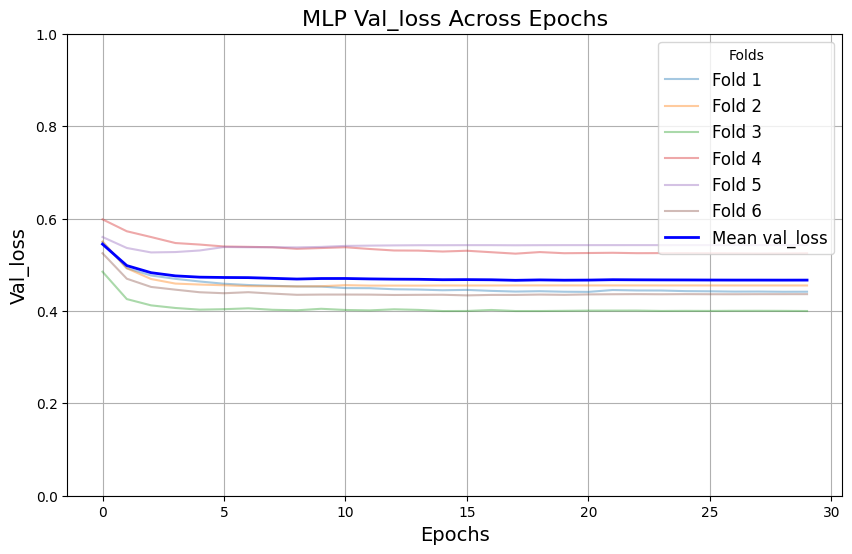

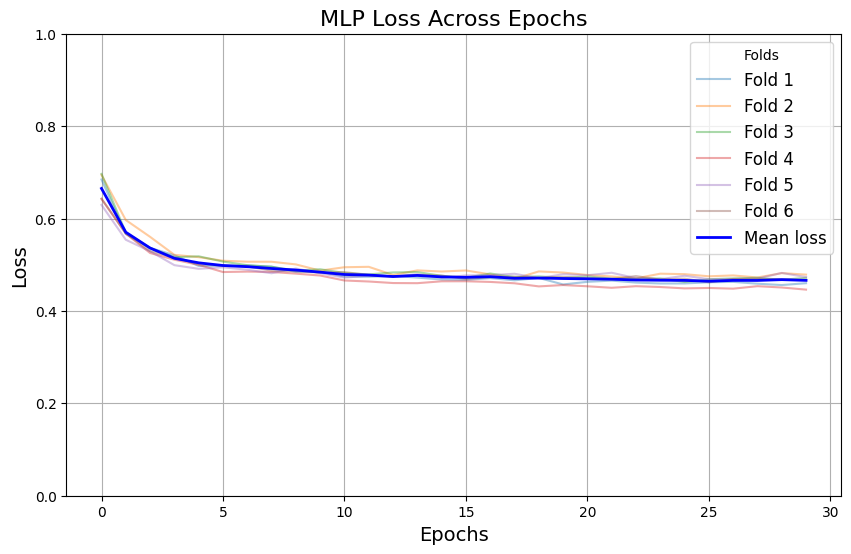

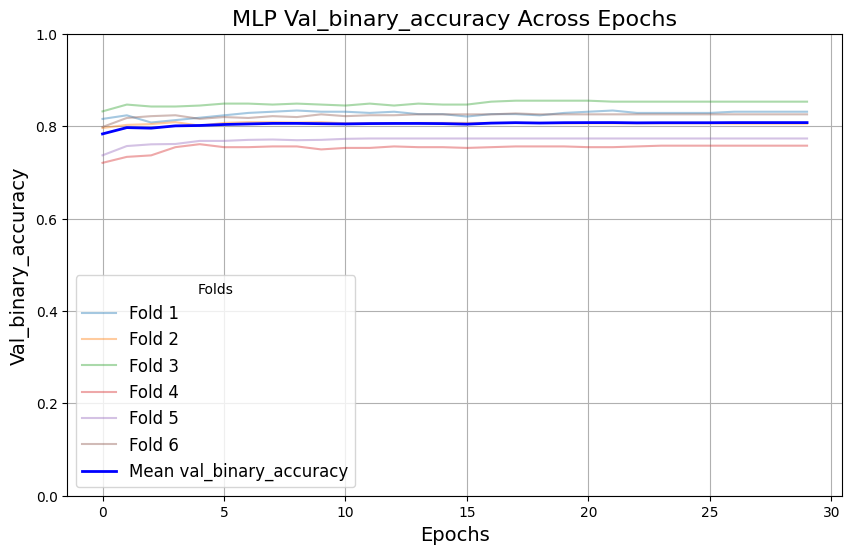

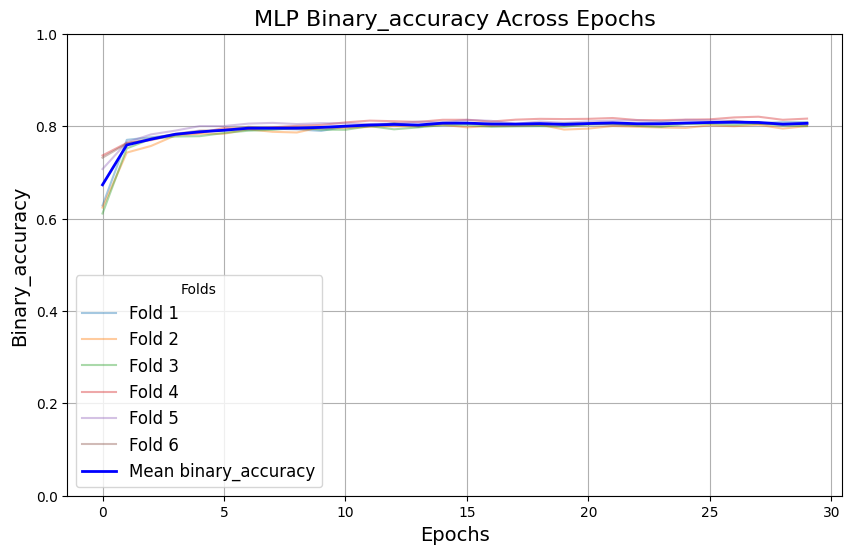

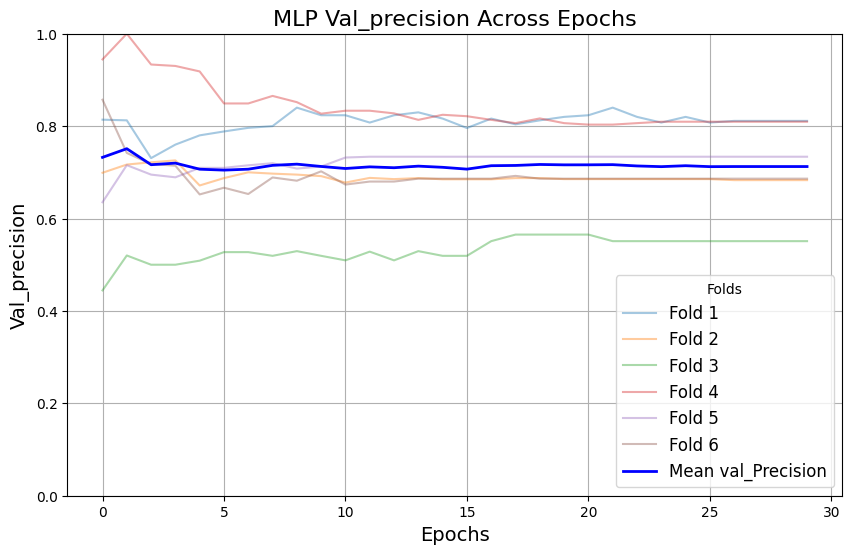

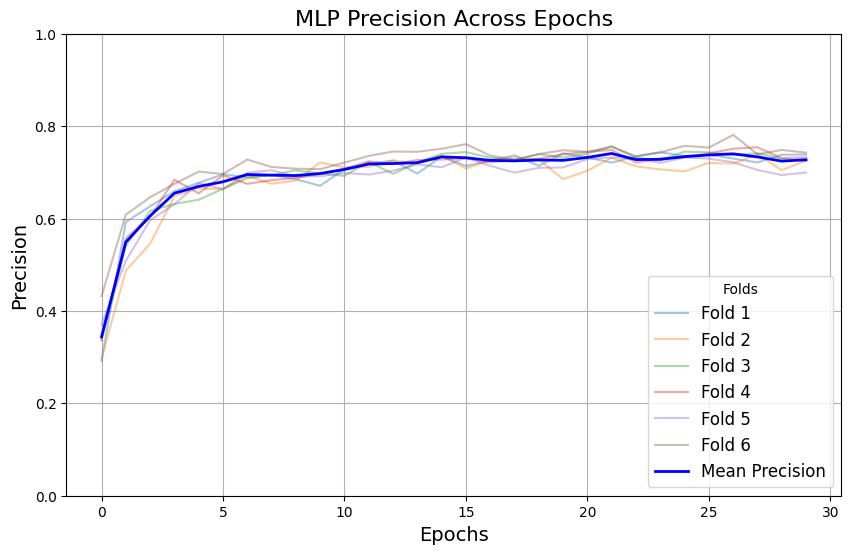

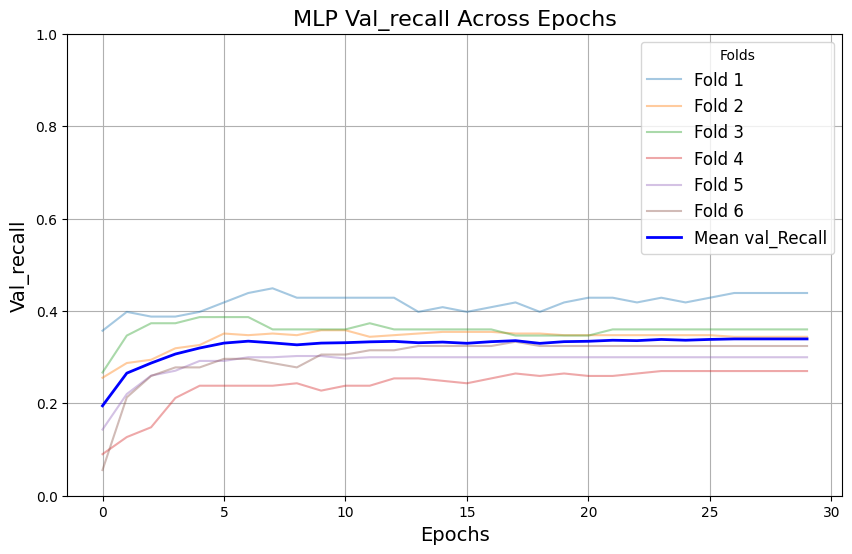

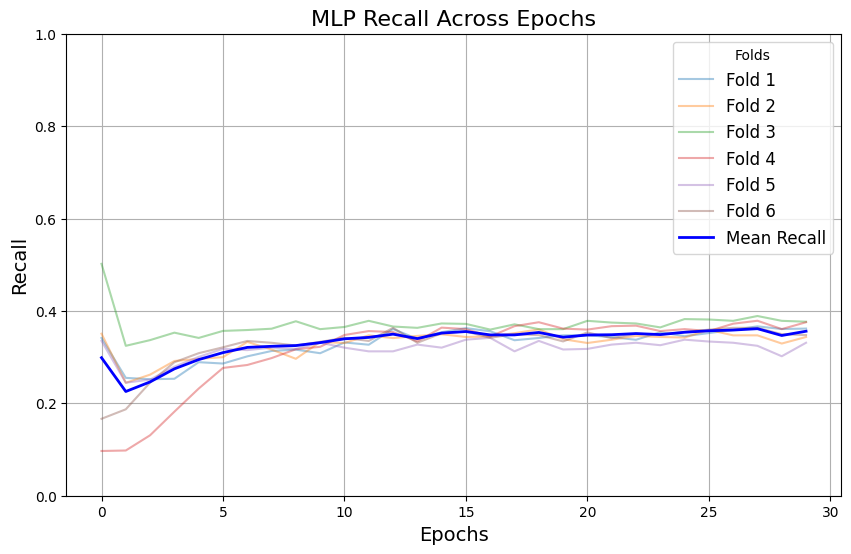

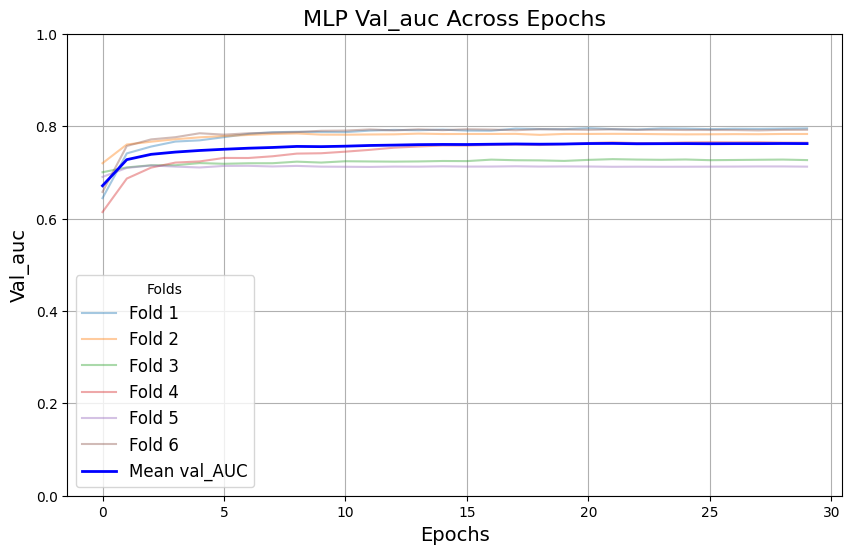

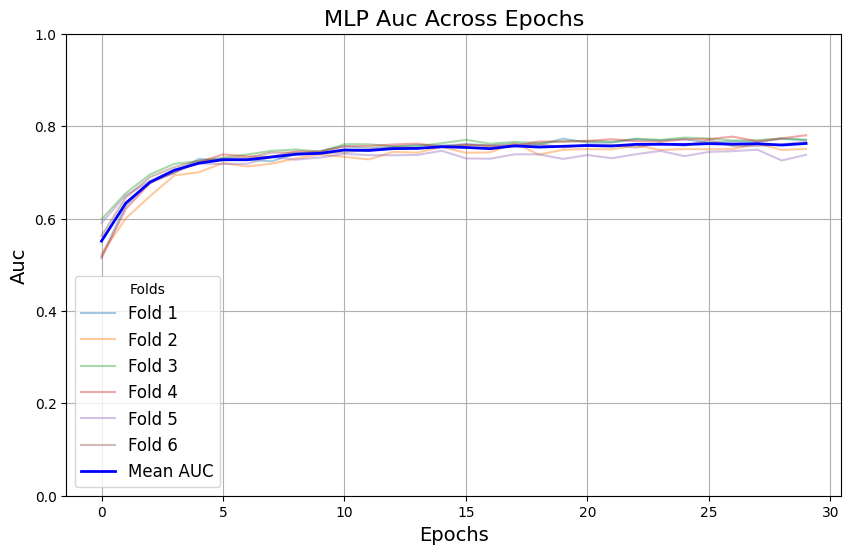

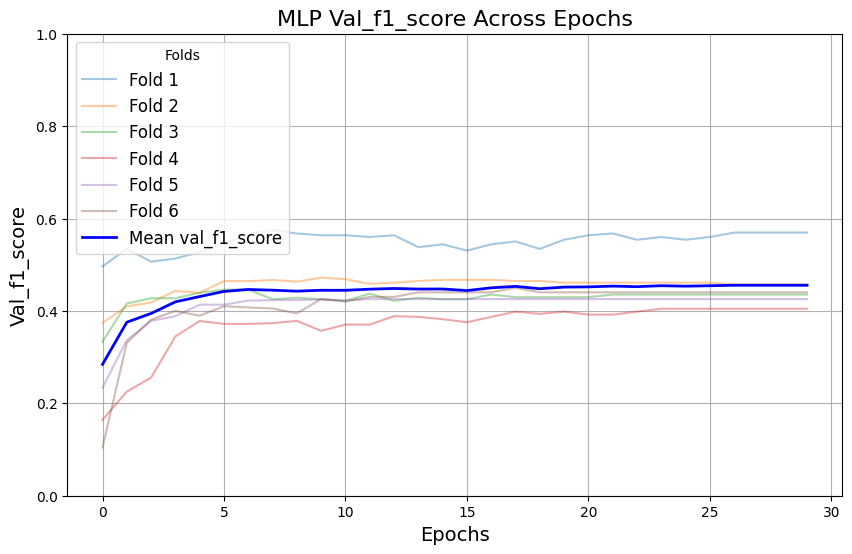

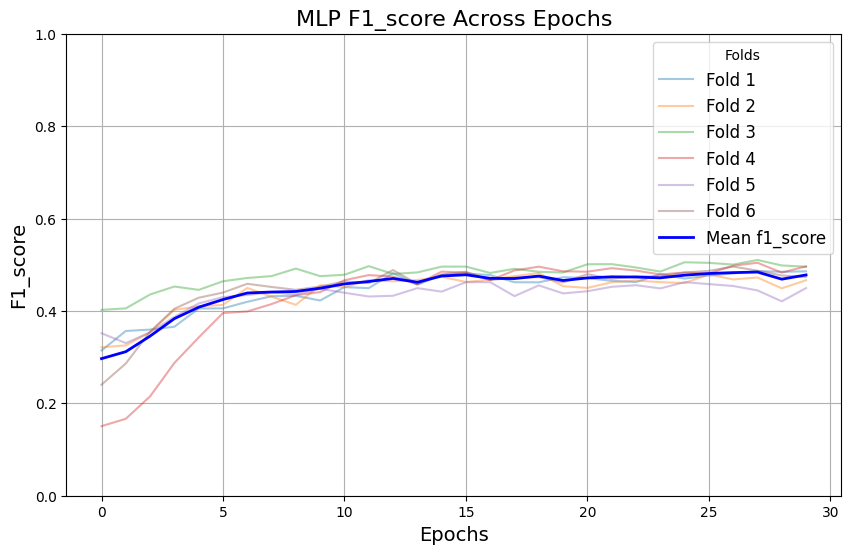

In [ ]:
# plot val loss, train loss, val accuracy, train accuracy, val precision, train precision
plot_metric('val_loss')
plot_metric('loss')
plot_metric('val_binary_accuracy')
plot_metric('binary_accuracy')
plot_metric('val_Precision')
plot_metric('Precision')
plot_metric('val_Recall')
plot_metric('Recall')
plot_metric('val_AUC')
plot_metric('AUC')
plot_metric('val_f1_score')
plot_metric('f1_score')

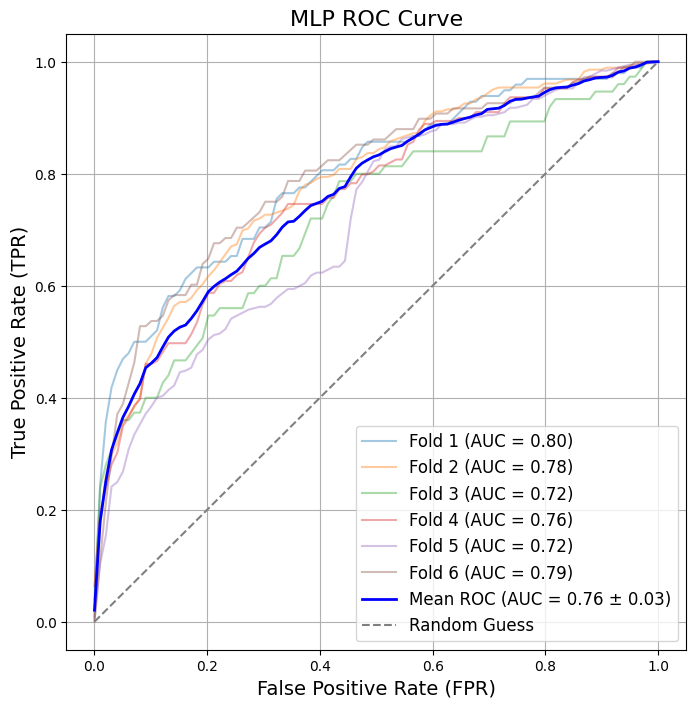

In [ ]:
### Plot ROC curve
plt.figure(figsize=(8, 8))

# Plot individual fold ROC curves
for i, (interp_roc, auc) in enumerate(zip(interp_rocs, scoring['roc_auc_test'])):
    plt.plot(interp, interp_roc, alpha=0.4, label=f'Fold {i+1} (AUC = {auc:.2f})')

# Compute and plot the mean ROC curve and its AUC
mean_roc = np.mean(interp_rocs, axis=0)
mean_roc[-1] = 1.0  # Ensure the curve ends at (1, 1)
mean_auc = np.mean(scoring['roc_auc_test'])
std_auc = np.std(scoring['roc_auc_test'])
plt.plot(np.linspace(0, 1, 100), mean_roc, color='blue', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)

# Plot diagonal line for random guessing
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')

# Finalize the plot
plt.title('MLP ROC Curve', fontsize=16)
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

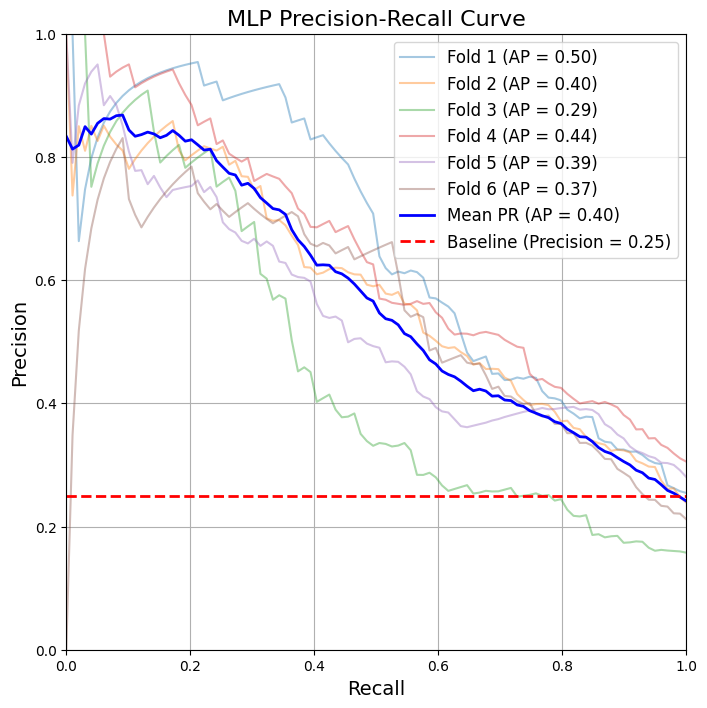

In [ ]:
# Plot the PR curve
plt.figure(figsize=(8, 8))

# Force to display x and y from 0 to 1
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# Plot individual fold PR curves
for i, interp_pr in enumerate(interp_prs):
    plt.plot(interp, interp_pr, alpha=0.4, label=f'Fold {i+1} (AP = {scoring["avg_pre_test"][i]:.2f})')

# Compute and plot the  mean PR curve
mean_pr = np.mean(interp_prs, axis=0)
mean_avg_precision = np.mean(scoring["avg_pre_test"])
plt.plot(np.linspace(0, 1, 100), mean_pr, color='blue', label=f'Mean PR (AP = {mean_avg_precision:.2f})', lw=2)

# Add the baseline
baseline_precision = 0.25
plt.axhline(y=baseline_precision, color='red', linestyle='--', label=f'Baseline (Precision = {baseline_precision:.2f})', lw=2)

# Finalize the plot
plt.title('MLP Precision-Recall Curve', fontsize=16)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.96      0.87      3387
           1       0.70      0.31      0.43      1129

    accuracy                           0.79      4516
   macro avg       0.75      0.63      0.65      4516
weighted avg       0.78      0.79      0.76      4516



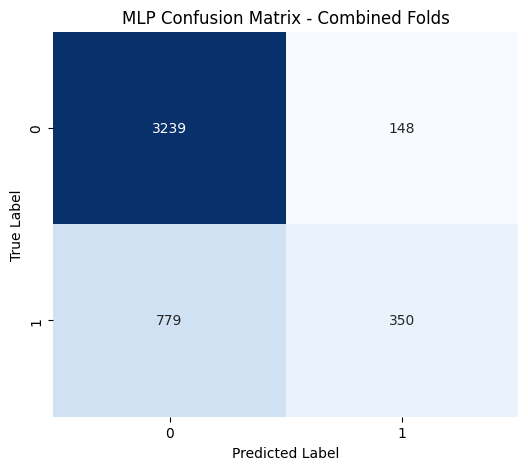

In [ ]:
## Confusion Matrix

# Convert lists to numpy arrays
y_true_combined = np.array(y_true_combined)
y_pred_combined = np.array(y_pred_combined)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_combined, y_pred_combined)

# Print classification report
print("Classification Report:\n", classification_report(y_true_combined, y_pred_combined))

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1], cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("MLP Confusion Matrix - Combined Folds")
plt.show()